In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))


In [2]:
import random
from typing import Any, List, Iterable, Tuple

import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision
from xml.etree import ElementTree

from my_project.di import get_injector
from my_project.directories.interface import InputDir


In [3]:
injector = get_injector()


In [4]:
input_dir = injector.get(InputDir)


In [5]:
def load_filenames(list_file: Path) -> Iterable[str]:
    with list_file.open("r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("#"):
                continue
            if not line:
                continue
            (img_name, _rest) = line.split(" ", 1)
            yield img_name


In [49]:
def load_bbox(file_path: Path) -> Tuple[int, int, int, int]:
    assert file_path.is_file(), file_path
    tree = ElementTree.parse(file_path)
    bbox = tree.find("./object/bndbox")
    xmin = int(bbox.find("./xmin").text)
    xmax = int(bbox.find("./xmax").text)
    ymin = int(bbox.find("./ymin").text)
    ymax = int(bbox.find("./ymax").text)
    return (xmin, ymin, xmax, ymax)


In [7]:
sample_xml_path = (
    input_dir / "pet" / "annotations" / "xmls" / "yorkshire_terrier_190.xml"
)
load_bbox(sample_xml_path)


(78, 62, 305, 256)

In [54]:
class PetDataset(torch.utils.data.Dataset):
    image_dir: Path
    xml_dir: Path
    image_names: List[str]

    def __init__(
        self, *, image_dir: Path, xml_dir: Path, list_file: Path, transform: Any
    ) -> None:
        super().__init__()
        assert image_dir.is_dir()
        assert xml_dir.is_dir()
        assert list_file.is_file()
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        self.image_names = [
            filename
            for filename in load_filenames(list_file)
            if (xml_dir / f"{filename}.xml").is_file()
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx: int) -> Tuple[Any, Any]:
        filename = self.image_names[idx]

        image_path = self.image_dir / f"{filename}.jpg"
        image = torchvision.io.read_image(
            str(image_path), mode=torchvision.io.ImageReadMode.RGB
        )

        annotation_path = self.xml_dir / f"{filename}.xml"
        bbox = load_bbox(annotation_path)
        bbox_tensor = torch.tensor(bbox, dtype=torch.float32)

        return image, bbox_tensor


In [70]:
ds = PetDataset(
    image_dir=input_dir / "pet" / "images",
    xml_dir=input_dir / "pet" / "annotations" / "xmls",
    list_file=input_dir / "pet" / "annotations" / "list.txt",
    transform=None,
)
len(ds)


3671

In [71]:
def preview_item(item: Tuple[torch.Tensor, torch.Tensor]) -> None:
    image, bbox = item
    image = image.permute(1, 2, 0).numpy()
    xmin, ymin, xmax, ymax = bbox.long().tolist()
    image = cv2.rectangle(
        image,
        (xmin, ymin),
        (xmax, ymax),
        (0, 255, 0),
        thickness=1,
    )
    plt.imshow(image)
    plt.show()


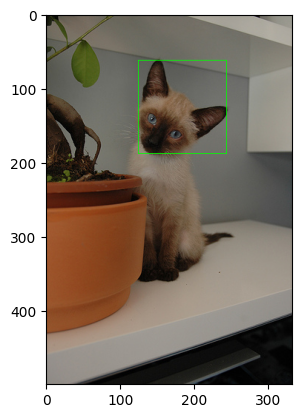

In [72]:
preview_item(ds[random.randint(0, len(train_ds) - 1)])


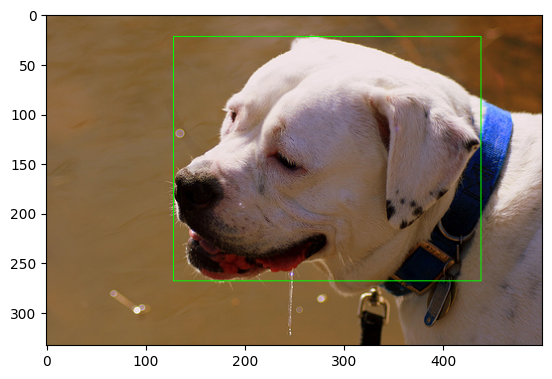

In [73]:
preview_item(ds[random.randint(0, len(train_ds) - 1)])
